# CR3BP : Effective Potential

This notebook renders contours, a colormap, and a 3D surface of the effective-potential (Omega) for each case.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import PowerNorm
from astropy import constants as const
from astropy import units as u

## User settings


In [4]:
PRIMARY_NAME = "Earth"
SECONDARY_NAME = "Moon"

M_PRIMARY = const.M_earth
M_SECONDARY = 7.34767309e22 * u.kg
mu_earth_moon = (M_SECONDARY / (M_PRIMARY + M_SECONDARY)).decompose().value
print(f"mu ({PRIMARY_NAME}-{SECONDARY_NAME}) = {mu_earth_moon:.12f}")

# Routh stability criterion threshold for L4/L5
MU_CRIT = 0.038520896504551

# Compare a small-mu demo case, Earth–Moon, and a large-mu demo case
mu_cases = [0.001, mu_earth_moon, 0.100]
case_names = ["Small", f"{PRIMARY_NAME}-{SECONDARY_NAME}", "Large"]

# Plot domain
x_min, x_max = -1.5, 1.5
y_min, y_max = -1.5, 1.5
nx, ny = 700, 700

# Numerical stabilization
eps_soft = 1e-6
r_cut = 0.02

# Colormap normalization (global, shared across cases)
gamma = 0.5
norm_lo_pct, norm_hi_pct = 0.0, 99.0

# Contours
n_contours = 20
contour_lo_pct, contour_hi_pct = 0.0, 99.0
contour_bias_power = 2.2

# 3D surface
surface_stride = 2
z_clip_percentiles = (0.0, 98.5)
view_elev, view_azim = 40, -70

CMAP = plt.get_cmap("nipy_spectral", 4096)

mu (Earth-Moon) = 0.012153663633


## Core functions


In [5]:
def effective_potential_Omega(x, y, mu, eps=1e-3):
    """CR3BP effective potential in rotating barycentric plane (z=0)."""
    x1, x2 = -mu, 1.0 - mu
    r1 = np.sqrt((x - x1) ** 2 + y ** 2 + eps ** 2)
    r2 = np.sqrt((x - x2) ** 2 + y ** 2 + eps ** 2)
    return 0.5 * (x**2 + y**2) + (1.0 - mu) / r1 + mu / r2


def dOmega_dx_on_x_axis(x, mu):
    x1, x2 = -mu, 1.0 - mu
    r1, r2 = np.abs(x - x1), np.abs(x - x2)
    if r1 == 0.0 or r2 == 0.0:
        return np.inf
    return x - (1.0 - mu) * (x - x1) / r1**3 - mu * (x - x2) / r2**3


def d2Omega_dx2_numeric(x, mu, h=1e-6):
    return (dOmega_dx_on_x_axis(x + h, mu) - dOmega_dx_on_x_axis(x - h, mu)) / (2.0 * h)


def newton_solve_collinear(x0, mu, tol=1e-14, max_iter=100):
    x = x0
    for _ in range(max_iter):
        f = dOmega_dx_on_x_axis(x, mu)
        fp = d2Omega_dx2_numeric(x, mu)
        if not np.isfinite(f) or not np.isfinite(fp) or fp == 0.0:
            break
        x_new = x - f / fp
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    raise RuntimeError("Newton method did not converge for a collinear point.")


def initial_guesses_collinear(mu):
    gamma0 = (mu / 3.0) ** (1.0 / 3.0)
    return (1.0 - mu - gamma0, 1.0 - mu + gamma0, -1.0 - (5.0 * mu / 12.0))


def compute_lagrange_points(mu):
    xL10, xL20, xL30 = initial_guesses_collinear(mu)
    xL1 = newton_solve_collinear(xL10, mu)
    xL2 = newton_solve_collinear(xL20, mu)
    xL3 = newton_solve_collinear(xL30, mu)
    xL4, yL4 = 0.5 - mu, np.sqrt(3.0) / 2.0
    xL5, yL5 = xL4, -yL4
    return {
        "L1": (xL1, 0.0),
        "L2": (xL2, 0.0),
        "L3": (xL3, 0.0),
        "L4": (xL4, yL4),
        "L5": (xL5, yL5),
    }


x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x, y)


def masked_Omega_grid(mu, eps=1e-3, rcut=0.05):
    Om = effective_potential_Omega(X, Y, mu, eps=eps)
    x1, y1 = -mu, 0.0
    x2, y2 = 1.0 - mu, 0.0
    r1 = np.sqrt((X - x1) ** 2 + (Y - y1) ** 2)
    r2 = np.sqrt((X - x2) ** 2 + (Y - y2) ** 2)
    mask = (r1 >= rcut) & (r2 >= rcut)
    return np.where(mask, Om, np.nan), (x1, y1), (x2, y2)

## Precompute all cases + global normalization


In [6]:
case_data = []
for mu_val in mu_cases:
    Om_masked, p1, p2 = masked_Omega_grid(mu_val, eps=eps_soft, rcut=r_cut)
    L = compute_lagrange_points(mu_val)
    case_data.append((mu_val, Om_masked, p1, p2, L))

all_vals = np.concatenate([Om[np.isfinite(Om)].ravel() for (_, Om, _, _, _) in case_data])
vmin_g, vmax_g = np.percentile(all_vals, [norm_lo_pct, norm_hi_pct])
norm_g = PowerNorm(gamma=gamma, vmin=vmin_g, vmax=vmax_g)

## Plot


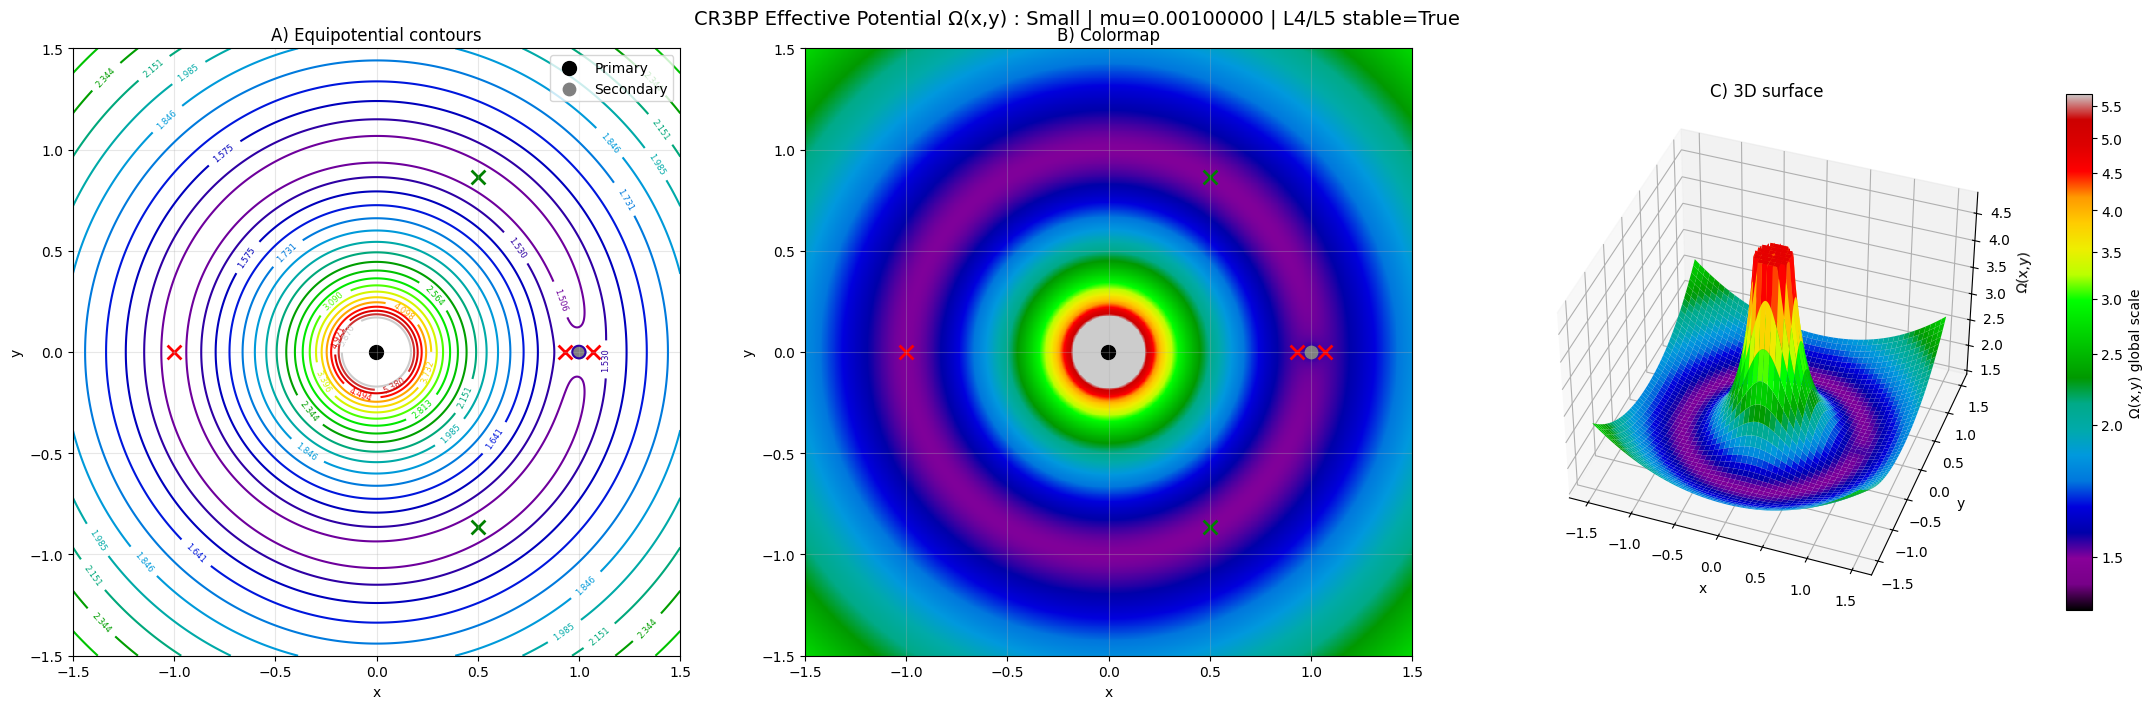

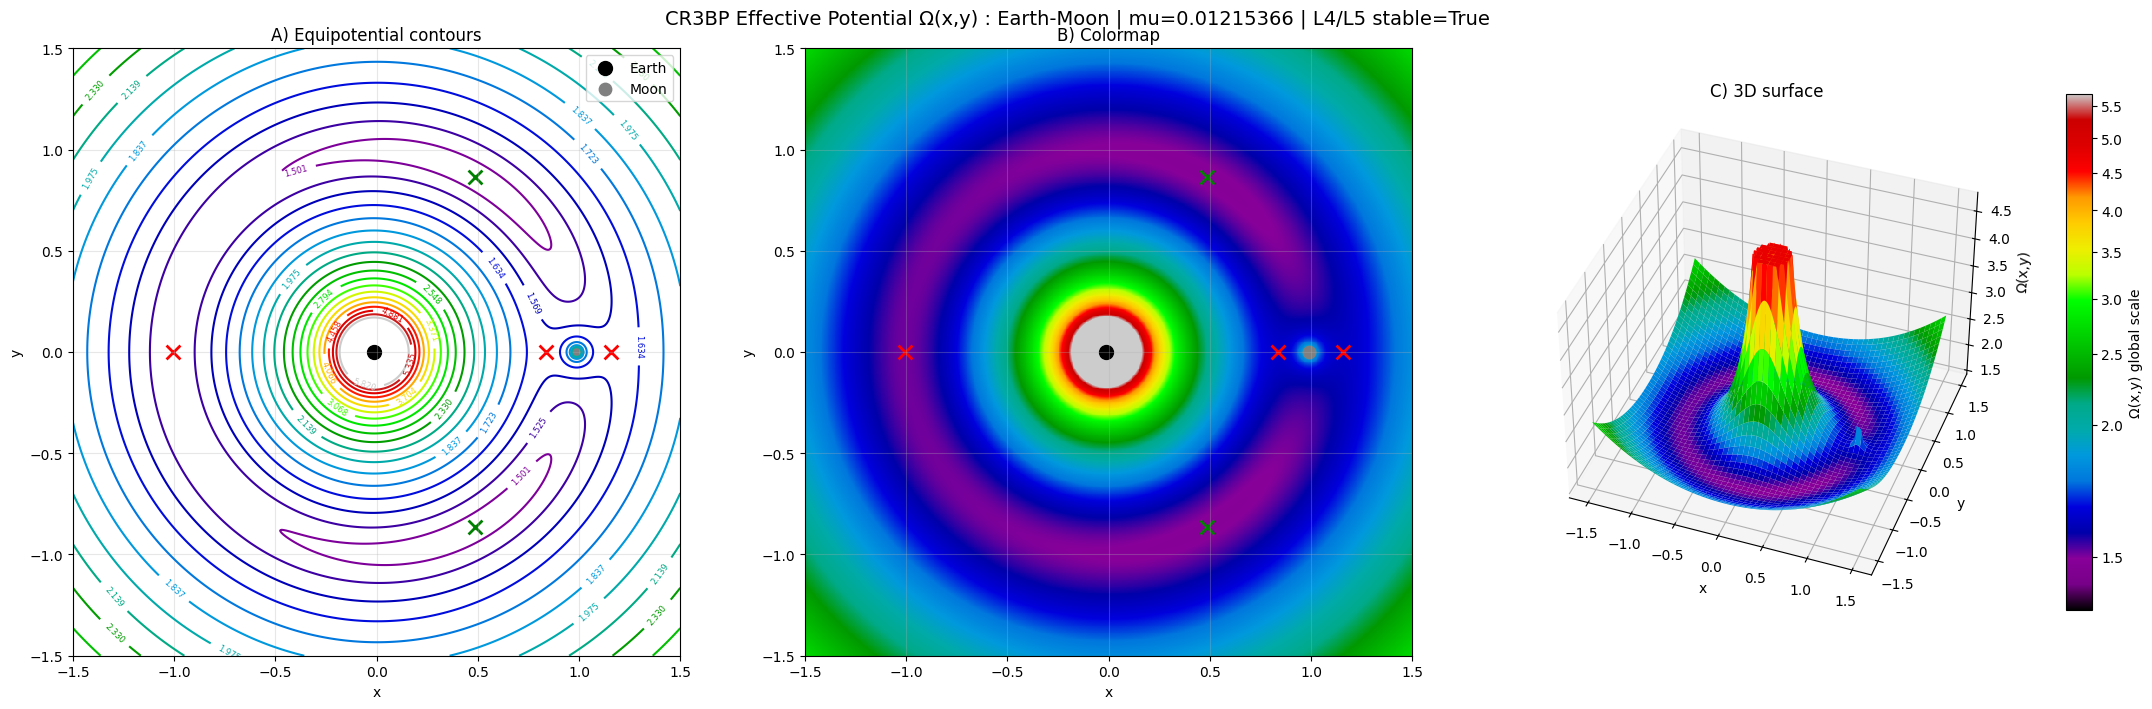

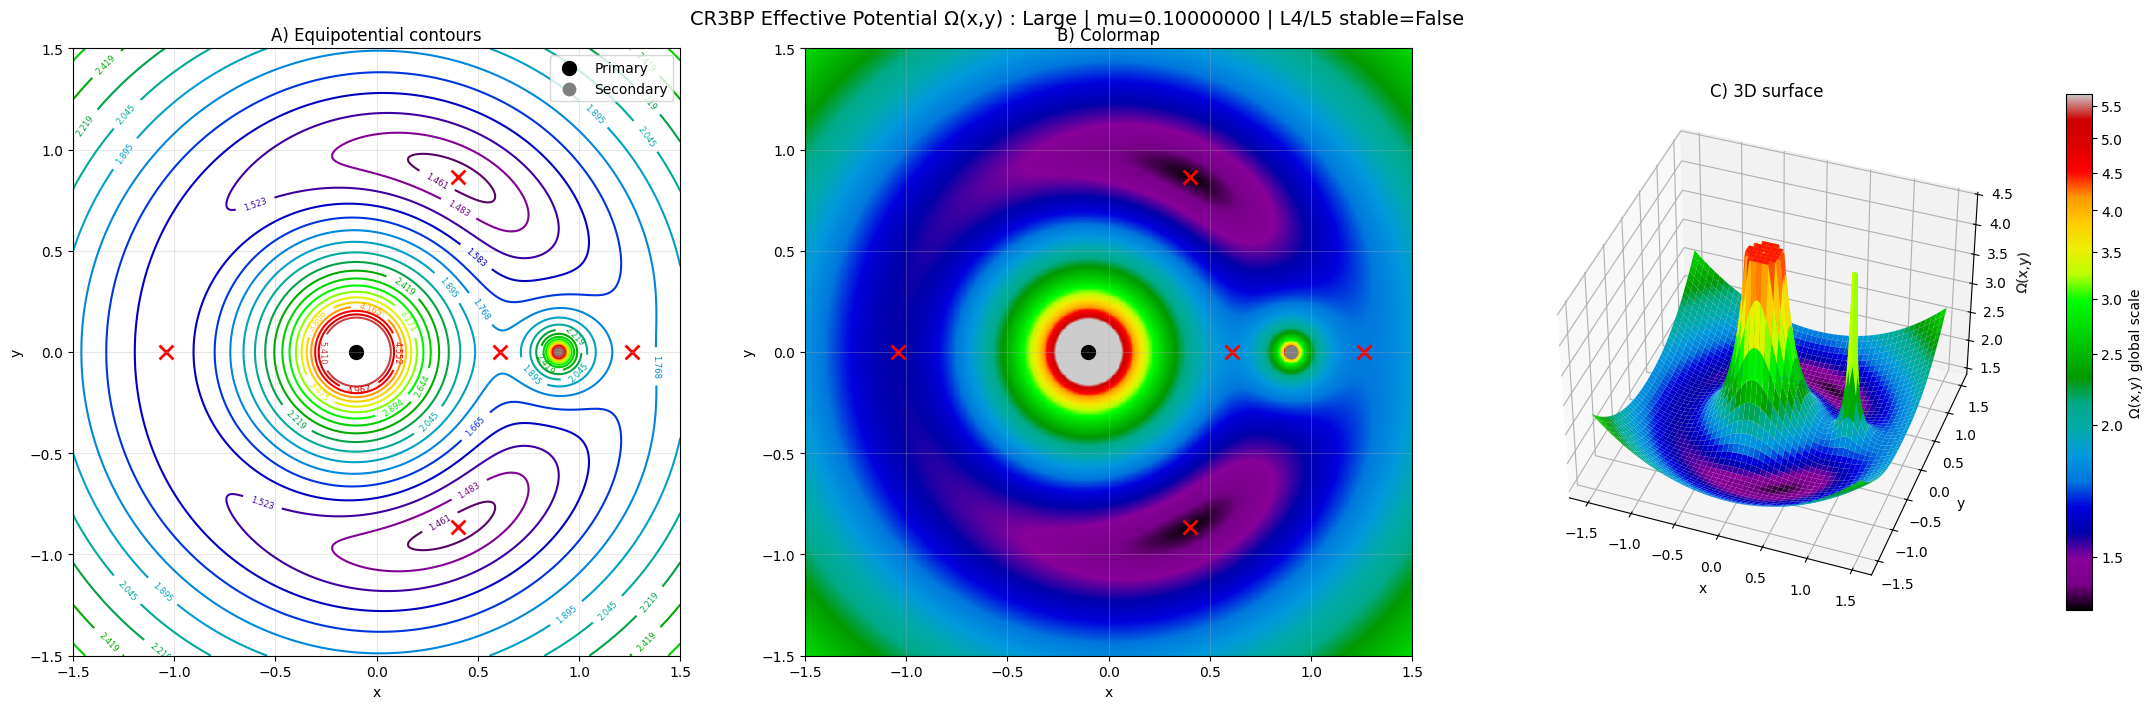

In [8]:
for (idx, (mu_val, Om, (x1p, y1p), (x2p, y2p), L)) in enumerate(case_data):
    stable_L45 = mu_val < MU_CRIT
    col_L45 = "green" if stable_L45 else "red"

    # Contour levels (biased to emphasize lower potential levels)
    vmin_c, vmax_c = np.nanpercentile(Om, [contour_lo_pct, contour_hi_pct])
    t = np.linspace(0.0, 1.0, n_contours)
    contour_levels = vmin_c + (vmax_c - vmin_c) * (t ** contour_bias_power)

    # 3D clipping
    z_lo, z_hi = np.nanpercentile(Om, list(z_clip_percentiles))
    Om3d = np.clip(Om, z_lo, z_hi)

    fig = plt.figure(figsize=(22, 7))
    fig.suptitle(
        f"CR3BP Effective Potential Ω(x,y) : {case_names[idx]} | mu={mu_val:.8f} | L4/L5 stable={stable_L45}",
        fontsize=14,
    )

    # A: Contours
    ax1 = fig.add_subplot(1, 3, 1)
    cs = ax1.contour(X, Y, Om, levels=contour_levels, cmap=CMAP, norm=norm_g)
    ax1.clabel(cs, inline=True, fontsize=6)
    ax1.scatter([x1p], [y1p], c="black", s=100, label=PRIMARY_NAME if idx == 1 else "Primary")
    ax1.scatter([x2p], [y2p], c="gray", s=80, label=SECONDARY_NAME if idx == 1 else "Secondary")
    for nm in ["L1", "L2", "L3"]:
        ax1.scatter([L[nm][0]], [L[nm][1]], c="red", marker="x", s=100, linewidths=2.0)
    for nm in ["L4", "L5"]:
        ax1.scatter([L[nm][0]], [L[nm][1]], c=col_L45, marker="x", s=100, linewidths=2.0)
    ax1.set_aspect("equal", "box")
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_title("A) Equipotential contours")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper right")

    # B: Colormap
    ax2 = fig.add_subplot(1, 3, 2)
    im = ax2.imshow(
        Om,
        extent=(x_min, x_max, y_min, y_max),
        origin="lower",
        cmap=CMAP,
        norm=norm_g,
        aspect="equal",
        interpolation="nearest",
    )
    ax2.scatter([x1p], [y1p], c="black", s=100)
    ax2.scatter([x2p], [y2p], c="gray", s=80)
    for nm in ["L1", "L2", "L3"]:
        ax2.scatter([L[nm][0]], [L[nm][1]], c="red", marker="x", s=100, linewidths=2.0)
    for nm in ["L4", "L5"]:
        ax2.scatter([L[nm][0]], [L[nm][1]], c=col_L45, marker="x", s=100, linewidths=2.0)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_title("B) Colormap")
    ax2.grid(True, alpha=0.3)

    # C: 3D surface
    ax3 = fig.add_subplot(1, 3, 3, projection="3d")
    surf = ax3.plot_surface(
        X[::surface_stride, ::surface_stride],
        Y[::surface_stride, ::surface_stride],
        Om3d[::surface_stride, ::surface_stride],
        cmap=CMAP,
        norm=norm_g,
        linewidth=0,
        antialiased=True,
    )
    ax3.view_init(elev=view_elev, azim=view_azim)
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_zlabel("Ω(x,y)")
    ax3.set_title("C) 3D surface")
    fig.colorbar(surf, ax=ax3, shrink=0.85, pad=0.08, label="Ω(x,y) global scale")

    plt.tight_layout()
    plt.show()